In [1]:
from tms_risk.utils import Subject

from braincoder.models import LogGaussianPRF
from braincoder.optimize import ResidualFitter
import numpy as np

from braincoder.utils import get_rsq

In [2]:
sub = Subject('05')

In [3]:
session = 1
roi = 'NPCr2cm-cluster'


pars = sub.get_prf_parameters_volume(session, smoothed=False, retroicor=False, denoise=True, cross_validated=False, natural_space=True, roi=roi)
data = sub.get_single_trial_volume(session, roi, smoothed=False, retroicor=False, denoise=True)
paradigm = sub.get_behavior(sessions=session, drop_no_responses=False)
paradigm = paradigm.droplevel(['subject', 'session'])


/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:250: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df.choice.isnull(), 'chose_risky'] = np.nan


In [4]:
mask = (pars['cvr2'] > 0.0)
mask.sum()

98

In [5]:
data = data.loc[:, mask]
pars = pars.loc[mask]

In [6]:
model = LogGaussianPRF(parameters=pars, paradigm=paradigm['n1'].astype(np.float32))
predictions = model.predict()

data.index = predictions.index

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

In [ ]:
get_rsq(data, predictions).sort_values()

28     0.028768
69     0.031504
18     0.032875
166    0.043076
45     0.045110
         ...   
259    0.257633
187    0.303184
172    0.318692
239    0.330163
174    0.347664
Length: 98, dtype: float32

In [ ]:
stimulus_range = np.arange(7, 28*4)

In [ ]:
model.init_pseudoWWT(stimulus_range=stimulus_range, parameters=pars)

residfit = ResidualFitter(model, data,
                            paradigm['n1'].astype(np.float32))

omega, dof = residfit.fit(init_sigma2=10.0,
        init_dof=10.0,
        method='t',
        learning_rate=0.005,
        max_n_iterations=20000)

(120, 98)
init_tau: 0.5865356922149658, 2.6235430240631104
USING A PSEUDO-WWT!
WWT max: 186.56192016601562


fit stat: 15320.6729 (best: 15320.6699, rho: 0.175, sigma2: 0.093, mean tau: 0.9409, dof: 15.7:  40%|████      | 8069/20000 [00:57<01:24, 140.51it/s]


<Axes: >

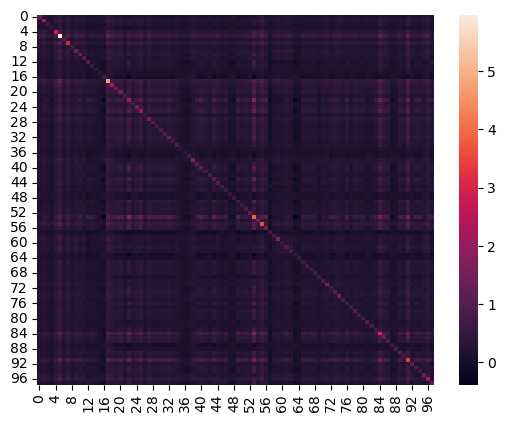

In [ ]:
import seaborn as sns
sns.heatmap(omega)

In [ ]:
fi = model.get_fisher_information(stimulus_range.astype(np.float32), omega, dof)

<Axes: xlabel='stimulus'>

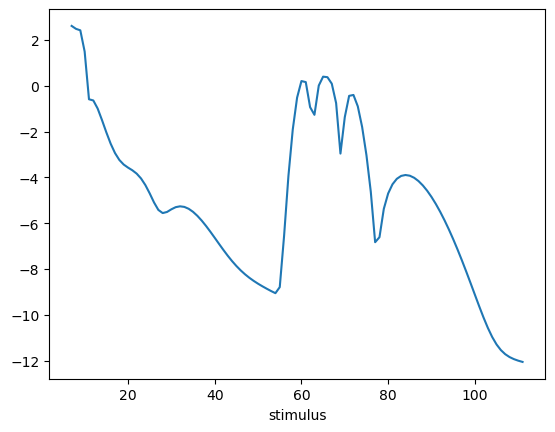

In [ ]:
np.sqrt(fi).plot()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83798/2410713605.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pars['mu'])


<Axes: xlabel='mu', ylabel='Density'>

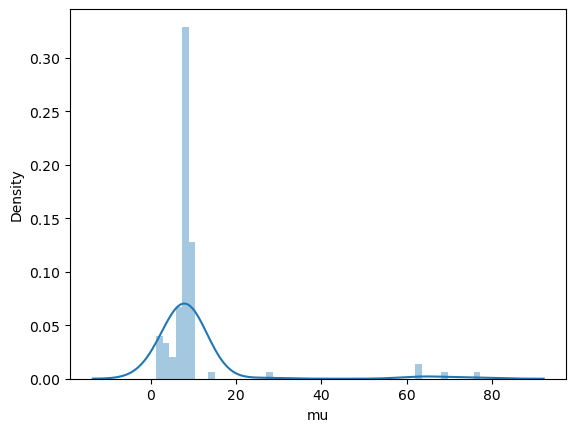

In [137]:
sns.distplot(pars['mu'])